In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from shapely.geometry import Point
from scipy.optimize import minimize, minimize_scalar
from scipy.stats import chi2

In [82]:
df = pd.read_csv('ACRA_w_SO.csv')

# Drop rows where Coordinate_X or Coordinate_Y is -1
df = df[(df['Coordinate_X'] != -1) & (df['Coordinate_Y'] != -1)]

# Initialise new dataframe for data we want to analyse
df_analysis = pd.DataFrame()
df_analysis['uen'] = df['uen']
df_analysis['Sector'] = df['Sector']
df_analysis['status'] = df['status']

# Convert the 5 struck off dates to datetime
date_cols = [f'Struck Off Date {i}' for i in range(1, 6)]
df[date_cols] = df[date_cols].apply(pd.to_datetime)

# Calculate the average date for each firm
df_analysis['Exit Date'] = df[date_cols].mean(axis=1)

# Convert Entry Date to datetime
df_analysis['Entry Date'] = df['registration_incorporation_date']
df_analysis['Entry Date'] = pd.to_datetime(df_analysis['Entry Date'])

In [83]:
# Read the geojson file
regions = gpd.read_file('region_boundary.geojson')
regions = regions.to_crs("EPSG:3414") # Convert to Singapore CRS

# Map the region names to the corresponding codes
region_map = {
    'kml_1': 'WR',
    'kml_2': 'NR',
    'kml_3': 'NER',
    'kml_4': 'ER',
    'kml_5': 'CR'
}
regions['Name'] = regions['Name'].map(region_map)

# Create a GeoDataFrame from the df DataFrame
geometry = [Point(xy) for xy in zip(df['Coordinate_X'], df['Coordinate_Y'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:3414")

# Spatial join: assign each firm the region it falls into
gdf_with_region = gpd.sjoin(gdf, regions, how='left', predicate='within')

# Update df_analysis with the mapped region assignments
df_analysis['Region'] = gdf_with_region['Name'].values

In [84]:
df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER


Functions

In [85]:
def plot_age_distribution(df, *, year='2023', sector=None, label=None):
    """
    Plot the age distribution of firms.
    
    Parameters:
    df: DataFrame containing the firms.
    year: The year to filter the firms by.
    sector: The sector to filter the firms by (optional).
    label: Label for the plot (optional).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Ensure 'Entry Date' and 'Exit Date' are datetime objects
    df['Entry Date'] = pd.to_datetime(df['Entry Date'])
    df['Exit Date'] = pd.to_datetime(df['Exit Date'], errors='coerce')
    # Convert year to datetime object
    date = pd.to_datetime(year + '-01-01') 

    # Filter firms alive at the given date
    df_filtered = df.copy()
    df_filtered = df[
        (df['Entry Date'] < date) &
        ((df['Exit Date'].isna()) | (df['Exit Date'] > date))
    ].copy()
    df_filtered['Exit Date'] = date
    df_filtered['Age'] = (date - df_filtered['Entry Date']).dt.days / 365.25

    # Filter by sector if provided
    if sector is not None:
        df_filtered = df_filtered[df_filtered['Sector'] == sector]
    
    # Line plot for age density
    counts, bin_edges = np.histogram(df_filtered['Age'].dropna(), bins=50)
    # Calculate bin midpoints
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(
        bin_midpoints,
        counts / counts.sum(),  # Normalize to get density
        label=label
    )

def log_likelihood(mu, alive_counts, dead_counts):
    phi = 1 - mu # Say phi is the survival probability (i.e. phi = 1 - mu)
    log_p = 0
    for i in range(1, len(alive_counts)):
        log_p += dead_counts[i]*(np.log(1-pow(phi, i))) + alive_counts[i] * i * np.log(phi)
    return log_p

def neg_log_likelihood(params, alive_counts1, dead_counts1, alive_counts2, dead_counts2):
    mu1, mu2 = params
    ll1 = log_likelihood(mu1, alive_counts1, dead_counts1)
    ll2 = log_likelihood(mu2, alive_counts2, dead_counts2)
    return -(ll1 + ll2)  # negative for minimization

# Function to perform the likelihood ratio test
# 
def likelihood_ratio_test(df_a, df_b):
    """
    Perform the likelihood ratio test to compare the death rates across two dataframes.
    where H0: Death rate is constant across df_a and df_b
    and H1: Death rate is not constant across df_a and df_b
    
    Parameters:
    df_a: DataFrame containing the first set of firms.
    df_b: DataFrame containing the second set of firms.
    
    Returns:
    lrt_statistic: Likelihood ratio test statistic
    p_value: p-value for the test
    """
    
    df1 = df_a.copy()
    df2 = df_b.copy()

    # Create list of 31 years from 1992 to 2022
    years = np.arange(1992, 2023, 1)
    years = years[::-1]

    # Convert Entry Date to only show the year
    df1['Entry Date'] = df1['Entry Date'].dt.year
    df2['Entry Date'] = df2['Entry Date'].dt.year

    # Create list of counts of alive/dead firms for each year for NR
    alive_counts_1 = []
    dead_counts_1 = []
    alive_counts_2 = []
    dead_counts_2 = []
    for year in years:
        alive_count1 = df1[
            (df1['Entry Date'] == year) &
            (df1['Exit Date'].isna())
        ].shape[0]
        alive_counts_1.append(alive_count1)

        dead_count1 = df1[
            (df1['Entry Date'] == year) &
            (df1['status'] == 0)
        ].shape[0]
        dead_counts_1.append(dead_count1)

        alive_count2 = df2[
            (df2['Entry Date'] == year) &
            (df2['Exit Date'].isna())
        ].shape[0]
        alive_counts_2.append(alive_count2)

        dead_count2 = df2[
            (df2['Entry Date'] == year) &
            (df2['status'] == 0)
        ].shape[0]
        dead_counts_2.append(dead_count2)

    # Calculate the MLE for H0
    mu_mle = minimize_scalar(
        lambda mu: -log_likelihood(mu, alive_counts_1, dead_counts_1) - log_likelihood(mu, alive_counts_2, dead_counts_2),
        bounds=(0.01, 0.99),
        method='bounded'
    ).x

    # Calculate the log-likelihood for H0
    ll_h0 = log_likelihood(mu_mle, alive_counts_1, dead_counts_1) + log_likelihood(mu_mle, alive_counts_2, dead_counts_2)

    # Calculate the MLE for H1
    result = minimize(
        neg_log_likelihood,
        x0=[0.1, 0.1],  # initial guess for mu1 and mu2
        args=(alive_counts_1, dead_counts_1, alive_counts_2, dead_counts_2),
        bounds=[(0.01, 0.99), (0.01, 0.99)]
    )
    mu_1_mle, mu_2_mle = result.x

    # Calculate the log-likelihood for H1
    ll_h1 = log_likelihood(mu_1_mle, alive_counts_1, dead_counts_1) + log_likelihood(mu_2_mle, alive_counts_2, dead_counts_2)

    # Calculate the likelihood ratio test statistic
    lrt_statistic = 2 * (ll_h1 - ll_h0)

    # Calculate the p-value for the likelihood ratio test
    p_value = chi2.sf(lrt_statistic, df=1)

    return lrt_statistic, p_value, mu_mle, mu_1_mle, mu_2_mle

# Create filtered dataframes
def filter_dataframe(category, filter, *, category2 = None, filter2 = None):
    """
    Filter the df_analysis dataframe based on the given category and filter.
    If category2 and filter2 are provided, it will filter based on both conditions.
    """
    if category2 is not None and filter2 is not None:
        df = df_analysis.copy()
        df = df[(df[category] == filter) & (df[category2] == filter2)]
    else:
        df = df_analysis.copy()
        df = df[df[category] == filter]
        
    return df

def plot_survival_fractions(df, label):
    """
    Plot survival fractions against age.
    """

    # Create list of ages from 0 to 60
    ages_sf = np.arange(0, 61, 1)
    # Create list of 31 years from 1962 to 2022
    years = np.arange(1962, 2023, 1)
    years = years[::-1]

    # Convert Entry Date to only show the year
    df['Entry Date'] = df['Entry Date'].dt.year

    # Create list of alive/dead firms for each year
    alive_counts = []
    dead_counts = []
    for year in years:
        alive_count = df[
            (df['Entry Date'] == year) &
            (df['Exit Date'].isna())
        ].shape[0]
        alive_counts.append(alive_count)

        dead_count = df[
            (df['Entry Date'] == year) &
            (df['status'] == 0)
        ].shape[0]
        dead_counts.append(dead_count)

    # Create list of survival fractions
    survival_fractions = np.array(alive_counts) / (np.array(alive_counts) + np.array(dead_counts))

    plt.plot(ages_sf, survival_fractions, label=label, marker='o', markersize=3)

def plot_exponential(mu, *, label='Exponential Fit', linestyle='--'):
    """
    Plot the exponential survival function S(age) = exp(-mu * age).
    """
    ages = np.arange(0, 61, 1)
    survival_fractions = np.exp(-mu * ages)
    plt.plot(ages, survival_fractions, label=label, linestyle=linestyle)

Likelihood ratio tests, first chunk without sampling and second chunk with sampling

Sample size for df_a: 1027433
Sample size for df_b: 1666844
Likelihood Ratio Test Statistic: 86.29133023601025
P-value for the likelihood ratio test: 1.5528782760224526e-20
MLE for mu: 0.09950937552448068
MLE for mu_a: 0.09844143982937258 and MLE for mu_b: 0.10014498837186706
Reject H0: Death rates are different.


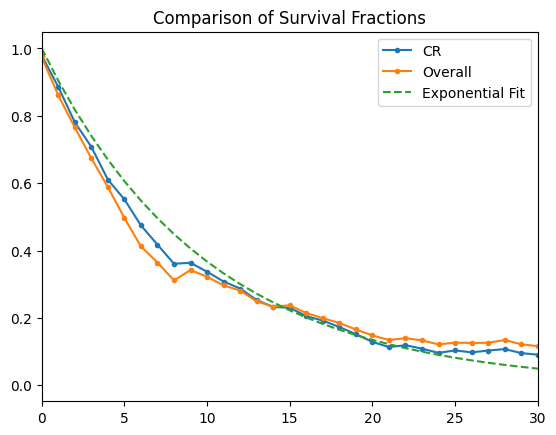

Sample size for df_a: 111817
Sample size for df_b: 1666844
Likelihood Ratio Test Statistic: 18.966457641217858
P-value for the likelihood ratio test: 1.3303674776865099e-05
MLE for mu: 0.10001483448479152
MLE for mu_a: 0.09828513043186972 and MLE for mu_b: 0.10014486848020941
Reject H0: Death rates are different.


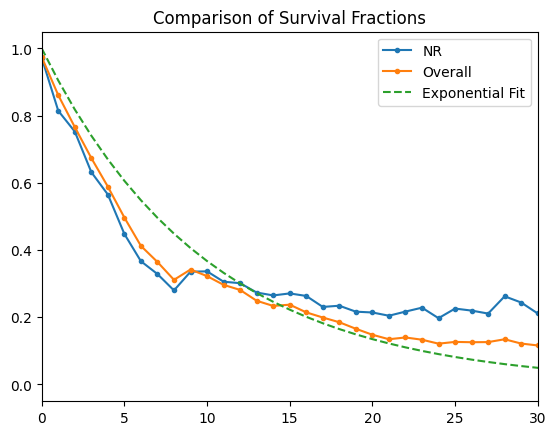

Sample size for df_a: 191979
Sample size for df_b: 1666844
Likelihood Ratio Test Statistic: 62.275030279764906
P-value for the likelihood ratio test: 2.98688345407257e-15
MLE for mu: 0.09984613405918044
MLE for mu_a: 0.09751344505536387 and MLE for mu_b: 0.10014489876462009
Reject H0: Death rates are different.


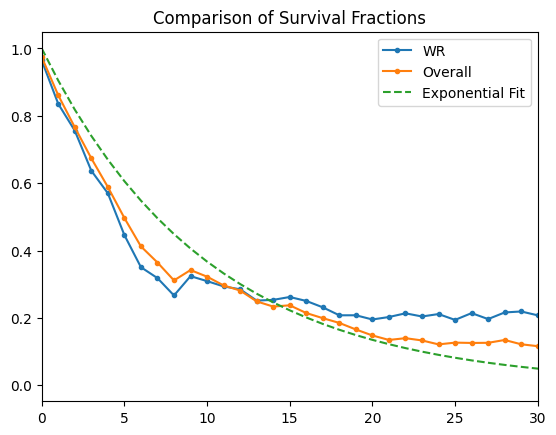

Sample size for df_a: 157204
Sample size for df_b: 1666844
Likelihood Ratio Test Statistic: 253.22586540784687
P-value for the likelihood ratio test: 5.142680951567973e-57
MLE for mu: 0.10067991058213342
MLE for mu_a: 0.10628120120154368 and MLE for mu_b: 0.10014497559010252
Reject H0: Death rates are different.


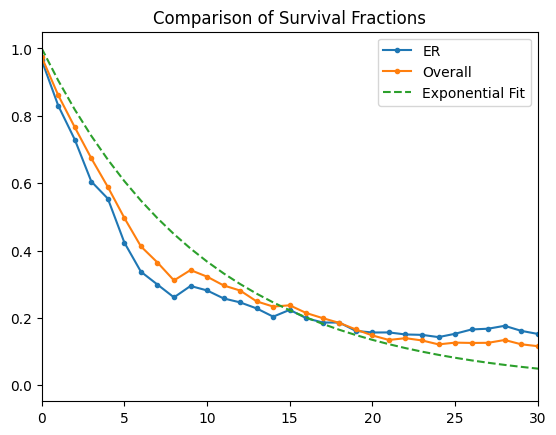

Sample size for df_a: 178411
Sample size for df_b: 1666844
Likelihood Ratio Test Statistic: 534.7389459938277
P-value for the likelihood ratio test: 2.63011054461053e-118
MLE for mu: 0.10096101343104179
MLE for mu_a: 0.10872635110138237 and MLE for mu_b: 0.10014497820220777
Reject H0: Death rates are different.


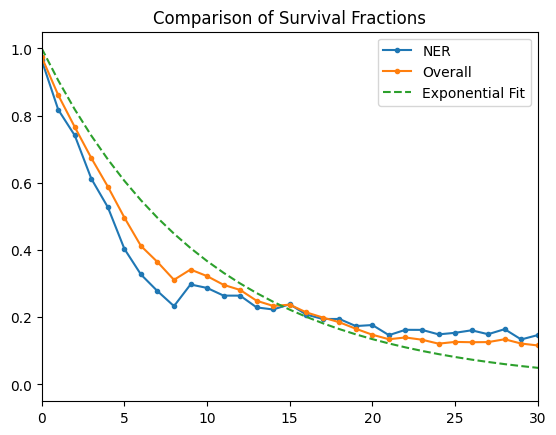

In [86]:
region_list = ['CR', 'NR', 'WR', 'ER', 'NER']
for region1 in region_list:
    df_a = filter_dataframe('Region', region1)
    df_b = df_analysis.copy()

    print(f'Sample size for df_a: {len(df_a)}')
    print(f'Sample size for df_b: {len(df_b)}')

    # Perform the likelihood ratio test
    lrt_statistic, p_value, mu_mle, mu_1, mu_2 = likelihood_ratio_test(df_a, df_b)
    print(f'Likelihood Ratio Test Statistic: {lrt_statistic}')
    print(f'P-value for the likelihood ratio test: {p_value}')
    print(f'MLE for mu: {mu_mle}') # Under H0
    print(f'MLE for mu_a: {mu_1} and MLE for mu_b: {mu_2}') # Under H1

    # Conclusion based on p-value
    if p_value < 0.05:
        print("Reject H0: Death rates are different.")
    else:
        print("Fail to reject H0: Death rates are not significantly different.")

    # Plot survival fractions against age
    plot_survival_fractions(df_a, label = region1)
    plot_survival_fractions(df_b, label = 'Overall')
    # Plot the exponential survival function
    plot_exponential(mu_2)
    
    plt.title('Comparison of Survival Fractions')
    plt.xlim(0, 30) # since survival fractions are approximately monotonic only to about age 30
    plt.legend()
    plt.show()

Sample size for df_a: 111817
Sample size for df_b: 1666844
Likelihood Ratio Test Statistic: 18.966457641217858
P-value for the likelihood ratio test: 1.3303674776865099e-05
MLE for mu: 0.10001483448479152
MLE for mu_a: 0.09828513043186972 and MLE for mu_b: 0.10014486848020941
Reject H0: Death rates are different.


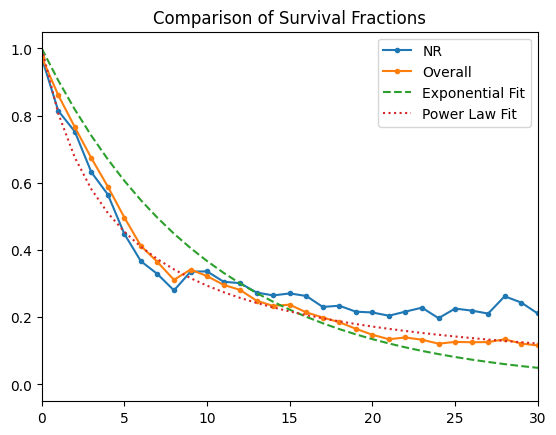

In [87]:
df_a = filter_dataframe('Region', 'NR')
df_b = df_analysis.copy()

print(f'Sample size for df_a: {len(df_a)}')
print(f'Sample size for df_b: {len(df_b)}')

# Perform the likelihood ratio test
lrt_statistic, p_value, mu_mle, mu_1, mu_2 = likelihood_ratio_test(df_a, df_b)
print(f'Likelihood Ratio Test Statistic: {lrt_statistic}')
print(f'P-value for the likelihood ratio test: {p_value}')
print(f'MLE for mu: {mu_mle}') # Under H0
print(f'MLE for mu_a: {mu_1} and MLE for mu_b: {mu_2}') # Under H1

# Conclusion based on p-value
if p_value < 0.05:
    print("Reject H0: Death rates are different.")
else:
    print("Fail to reject H0: Death rates are not significantly different.")

# Plot survival fractions against age
plot_survival_fractions(df_a, label = 'NR')
plot_survival_fractions(df_b, label = 'Overall')
# Plot the exponential survival function
plot_exponential(mu_2)
# Test plot for power law fit
ages = np.arange(0, 61, 1)
plt.plot(ages,(5/(1.2*ages+5)) , label='Power Law Fit', linestyle=':')

plt.title('Comparison of Survival Fractions')
plt.xlim(0, 30) # since survival fractions are approximately monotonic only to about age 30
plt.legend()
plt.show()

Sample size for df_a: 111817
Sample size for df_b: 191979
Likelihood Ratio Test Statistic: 2.261298032128252
P-value for the likelihood ratio test: 0.13264284040602534
MLE for mu: 0.09779774927418274
MLE for mu_a: 0.09828650123734556 and MLE for mu_b: 0.09751407814212187
Fail to reject H0: Death rates are not significantly different.


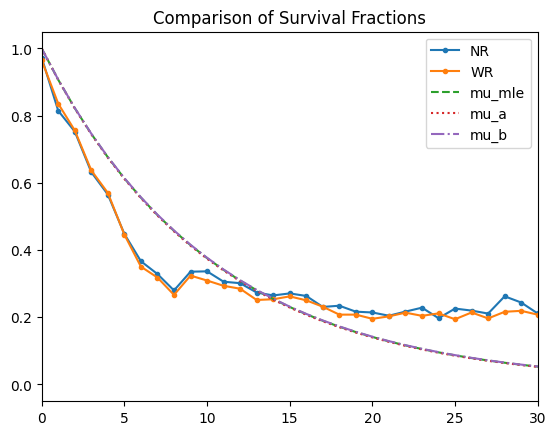

In [88]:
df_a = filter_dataframe('Region', 'NR')
df_b = filter_dataframe('Region', 'WR')

print(f'Sample size for df_a: {len(df_a)}')
print(f'Sample size for df_b: {len(df_b)}')

# Perform the likelihood ratio test
lrt_statistic, p_value, mu_mle, mu_1, mu_2 = likelihood_ratio_test(df_a, df_b)
print(f'Likelihood Ratio Test Statistic: {lrt_statistic}')
print(f'P-value for the likelihood ratio test: {p_value}')
print(f'MLE for mu: {mu_mle}') # Under H0
print(f'MLE for mu_a: {mu_1} and MLE for mu_b: {mu_2}') # Under H1

# Conclusion based on p-value
if p_value < 0.05:
    print("Reject H0: Death rates are different.")
else:
    print("Fail to reject H0: Death rates are not significantly different.")

# Plot survival fractions against age
plot_survival_fractions(df_a, label = 'NR')
plot_survival_fractions(df_b, label = 'WR')
# Plot the exponential survival function
plot_exponential(mu_mle, label='mu_mle', linestyle='--')
plot_exponential(mu_1, label='mu_a', linestyle=':')
plot_exponential(mu_2, label='mu_b', linestyle='-.')

plt.title('Comparison of Survival Fractions')
plt.xlim(0, 30) # since survival fractions are approximately monotonic only to about age 30
plt.legend()
plt.show()

Sample size for df_a: 100000
Sample size for df_b: 100000
Likelihood Ratio Test Statistic: 2.3130882071563974
P-value for the likelihood ratio test: 0.12828894436693525
MLE for mu: 0.09787648694683128
MLE for mu_a: 0.09741169878333443 and MLE for mu_b: 0.09834108668958687
Fail to reject H0: Death rates are not significantly different.


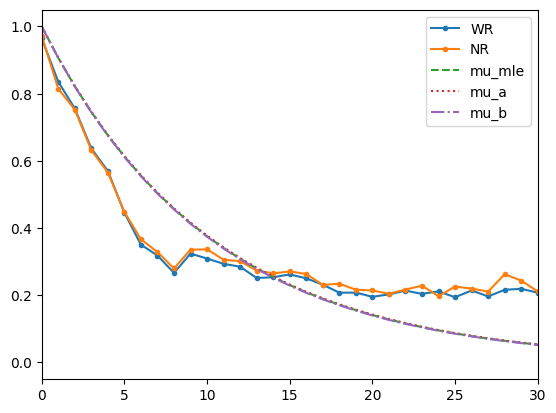

In [89]:
df_a = filter_dataframe('Region', 'WR')
df_b = filter_dataframe('Region', 'NR')

# Sample 10,000 firms from each DataFrame (with replacement if not enough rows)
df_a_sample = df_a.sample(n=100000, replace=(len(df_a) < 100000))
df_b_sample = df_b.sample(n=100000, replace=(len(df_b) < 100000))

print(f'Sample size for df_a: {len(df_a_sample)}')
print(f'Sample size for df_b: {len(df_b_sample)}')

# Perform the likelihood ratio test
lrt_statistic, p_value, mu_mle, mu_1, mu_2 = likelihood_ratio_test(df_a_sample, df_b_sample)
print(f'Likelihood Ratio Test Statistic: {lrt_statistic}')
print(f'P-value for the likelihood ratio test: {p_value}')
print(f'MLE for mu: {mu_mle}') # Under H0
print(f'MLE for mu_a: {mu_1} and MLE for mu_b: {mu_2}') # Under H1

# Conclusion based on p-value
if p_value < 0.05:
    print("Reject H0: Death rates are different.")
else:
    print("Fail to reject H0: Death rates are not significantly different.")

# Plot survival fractions against age
plot_survival_fractions(df_a, label = 'WR')
plot_survival_fractions(df_b, label = 'NR')
# Plot the exponential survival function
plot_exponential(mu_mle, label='mu_mle', linestyle='--')
plot_exponential(mu_1, label='mu_a', linestyle=':')
plot_exponential(mu_2, label='mu_b', linestyle='-.')

plt.xlim(0, 30)
plt.legend()
plt.show()